<a href="https://colab.research.google.com/github/peeyushsinghal/da_cv_fer/blob/main/da_cv_fer_sfew_expw_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cloning repository
Importing files regarding dataset, model, mains and utils

In [1]:
!git clone https://github.com/peeyushsinghal/da_cv_fer.git
import os
os.getcwd()
os.chdir('da_cv_fer')

Cloning into 'da_cv_fer'...
remote: Enumerating objects: 57, done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 57
Receiving objects: 100% (57/57), 1.04 MiB | 5.91 MiB/s, done.
Resolving deltas: 100% (26/26), done.


Installing dependencies

In [4]:
!pip install -q -r requirements.txt # -q is for quiet install
!pip install -q opendatasets # quient install, for some reason this does not get installed with requirements

ERROR: Could not find a version that satisfies the requirement pywin32==306 (from versions: none)
ERROR: No matching distribution found for pywin32==306


## Libraries and Initializations

In [16]:
# Installs from files
from da_cv_fer.data_config import DataConfig
from da_cv_fer.ds_sfew import DatasetSFEW
from da_cv_fer.ds_expw import EXPW
from da_cv_fer.utils import show_batch
from da_cv_fer.model_DANN import DANN
from da_cv_fer.run_config import RunConfig
from da_cv_fer.train import (weights_init,
                             train_model,
                             get_correct_predictions,
                             test_model)

import os
import zipfile

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm # for beautiful model training updates

import matplotlib.pyplot as plt # for plots

import time
from pathlib import Path

from copy import deepcopy
import numpy as np

### Initializing configs

In [6]:
#initializing dataconfig, it tells us about dataset configuration and directory structure
dataconfig = DataConfig()

## EXPW Dataset
Creating dataset and dataloader objects.
Split into train and val.

`details: da_cv_fer.ds_expw.EXPW`
<br>
Please be patient, it takes around 3 minutes to download data set

In [8]:
expw_obj = EXPW()
expw_train_ds, expw_val_ds = expw_obj.get_dataset()
expw_train_loader, expw_val_loader = expw_obj.get_dataloader()
print(f' length of EXPW dataset : {len(expw_train_loader.dataset)} , {len(expw_train_ds)}')

desitination file path = dataset/expwds/expwds.zip
Directory dataset/expwds already exists.
Unzipped Files already exist in dataset/expwds, not extracted
Directory dataset/expwds already exists.
Directory dataset/expwds already exists.
 length of EXPW dataset : 54476 , 54476


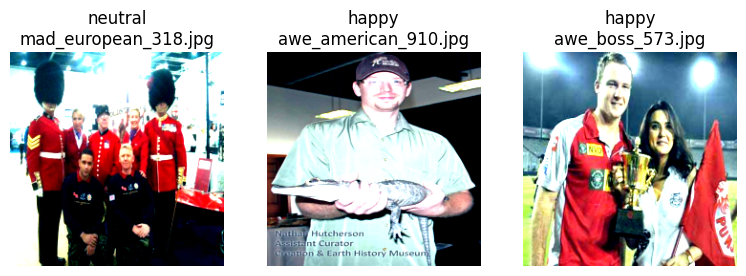

In [9]:
show_batch(expw_train_loader,expw_train_ds.labels,3)

## SFEW Dataset

Creating dataloader objects.

It copies files from a google drive, unzips it and sets that for use

details: da_cv_fer.ds_sfew.DatasetSFEW

In [10]:
# Mounting Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
sfew = DatasetSFEW()
sfew_train_loader, sfew_val_loader = sfew.get_dataloader()
print(f' length of SFEW dataset : {len(sfew_train_loader.dataset)}')

self.BASE_PATH -dataset,
 self.EXTRACT_DIR-dataset/sfew,
 self.ZIP_FILE_PATH - dataset/SFEW_2.zip 
Directory dataset/sfew created successfully.
No files (including zip file) found in dataset/sfew.Copying file
Starting File copying from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
File copied successfully from /content/gdrive/MyDrive/CV_FER/dataset/SFEW_2.zip to dataset/sfew
Initiating extraction of dataset/sfew/SFEW_2.zip to dataset/sfew
...completed for dataset/sfew/SFEW_2.zip
dataset/sfew/Train Fear.zip Fear
...completed for dataset/sfew/Train/Fear.zip
dataset/sfew/Train Sad.zip Sad
...completed for dataset/sfew/Train/Sad.zip
dataset/sfew/Train Surprise.zip Surprise
...completed for dataset/sfew/Train/Surprise.zip
dataset/sfew/Train Angry.zip Angry
...completed for dataset/sfew/Train/Angry.zip
dataset/sfew/Train Neutral.zip Neutral
...completed for dataset/sfew/Train/Neutral.zip
dataset/sfew/Train Disgust.zip Disgust
...completed for dataset/sfew/Train/Disgust.zi

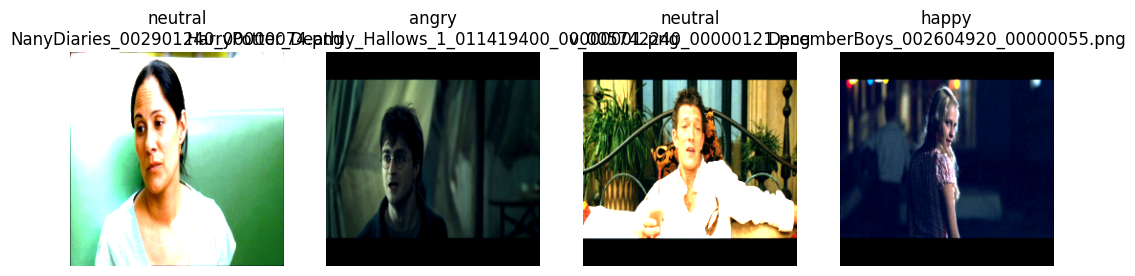

In [12]:
show_batch(sfew_train_loader,sfew.labels,4)

## Initializing Model

In [ ]:
model = DANN(num_classes=7, dropout=0.1)
model

### Checking Training - one forward pass
Useful to understand input and output. Specially, sizes of input and output (including batch sizes)

In [22]:
sfew_loader = {'name': 'sfew',
               'train':sfew_train_loader,
               'val':sfew_val_loader
               }

expw_loader = {'name': 'expw',
               'train':expw_train_loader,
               'val':expw_val_loader
               }

data_loader = {'source' : sfew_loader,
               'target' : expw_loader}

# data_loader = {'source_train_loader':sfew_train_loader,
#                'source_val_loader':sfew_val_loader,
#                'target_train_loader':expw_train_loader,
#                'target_val_loader':expw_val_loader}

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.to(device)

In [25]:
for usage, dict_data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(usage)

    # for name, train_loader, val_loader in data_loader.items()
    for k, v in dict_data_loader.items():
      if k == 'name':
        print (f'--------{k}:{v}------')
      elif k =='train':
        data_loader = v
        batch = next(iter(data_loader)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
        images, labels = batch[0].to(device), batch[1].to(device)
        print( "Input:\n","Input Image: ",images.shape, ",labels: ",labels.shape)

        x_labels, x_domains, x_features = model(images) # forward pass
        print("Output:\n", "labels: ", x_labels.shape, ",domains: ",x_domains.shape, ",features: ", x_features.shape)
      else:
        pass



--------------------------------------------------------------------------------
source
--------name:sfew------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
--------------------------------------------------------------------------------
target
--------name:expw------
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])


In [17]:

for name, data_loader in data_loader.items(): #[sfew_train_loader,sfew_val_loader,expw_train_loader,expw_val_loader]:
    print('-'*80)
    print(name)

    batch = next(iter(data_loader)) # it may be possible that some datasets have more than 2 outputs, so this strategy is safe
    images, labels = batch[0].to(device), batch[1].to(device)
    print( "Input:\n","Input Image: ",images.shape, ",labels: ",labels.shape)

    x_labels, x_domains, x_features = model(images) # forward pass
    print("Output:\n", "labels: ", x_labels.shape, ",domains: ",x_domains.shape, ",features: ", x_features.shape)


--------------------------------------------------------------------------------
source_train_loader
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
--------------------------------------------------------------------------------
source_val_loader
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
--------------------------------------------------------------------------------
target_train_loader
Input:
 Input Image:  torch.Size([32, 3, 224, 224]) ,labels:  torch.Size([32, 7])
Output:
 labels:  torch.Size([32, 7]) ,domains:  torch.Size([32, 2]) ,features:  torch.Size([32, 1000])
--------------------------------------------------------------------------------
target_val_loader
Input:
 Input Image:  torch.Size([32, 3, 2

In [ ]:
# #@title Weight Initialization

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       nn.init.xavier_normal_(m.weight)
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight)
#       nn.init.zeros_(m.bias)

# # initializating weights using xavier normal
# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#       # nn.init.xavier_normal_(m.weight)
#       pass # not initialising Conv layers as they are pretrained
#     elif isinstance(m, nn.Linear):
#       nn.init.xavier_normal_(m.weight) # Linear layers are added on
#       nn.init.zeros_(m.bias)

In [ ]:
# #@title Typical Training Function with Learning rate

# def train_model(model,device, data_loader, optimizer, epoch,
#                 class_loss_function = nn.CrossEntropyLoss() ):
#     print(f'epoch = {epoch+1}...in training function')

#     model.train() # setting model to training
#     model.to(device)

#     pbar = tqdm(data_loader) # putting the dataloader in progress bar

#     processed = 0 # to understand accuracy, used in denominator
#     epoch_loss = 0.0

#     for batch_idx, batch in enumerate(pbar):
#         images, labels = batch[0].to(device), batch[1].to(device) # batch of images and labels

#         optimizer.zero_grad() # setting gradients to zero to avoid accumulation

#         class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}

#         class_loss = class_loss_function(class_output,labels) # Calculate Loss
#         epoch_loss += class_loss.item()

#         class_loss.backward() #backpropogation, creating gradients

#         optimizer.step() # updating the params

#         processed += len(images)
#         curr_lr = optimizer.param_groups[0]['lr']

#         pbar.set_description(desc= f'Loss={class_loss.item()} Batch_id={batch_idx+1} Epoch Average loss={epoch_loss/processed:0.8f} LR={curr_lr:0.6f}')

#     return float("{:.8f}".format(epoch_loss/processed)),  curr_lr

In [ ]:
# def get_correct_predictions(prediction, labels):
#     """
#     Function to return total number of correct predictions
#     :param prediction: Model predictions on a given sample of data
#     :param labels: Correct labels of a given sample of data
#     :return: Number of correct predictions
#     """
#     # print(prediction)
#     # print(prediction.argmax(dim=1))
#     # print(f'labels = {labels}, labels.argmax ={labels.argmax(dim=1)}')
#     # # print(prediction.argmax(dim=1).eq(labels))
#     # # print(prediction.argmax(dim=1).eq(labels).sum())
#     # # print(prediction.argmax(dim=1).eq(labels).sum().item())
#     # # return prediction.argmax(dim=1).eq(labels).sum().item()
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum())
#     # print(prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item())
#     return prediction.argmax(dim=1).eq(labels.argmax(dim=1)).sum().item()

In [ ]:


# #@title Typical Test Function
# def test_model(model, device, data_loader, mode= 'test',
#                class_loss_function = nn.CrossEntropyLoss() ):
#     model.eval() # evaluation mode

#     # variables to track loss and accuracy
#     test_loss = 0.0
#     correct = 0

#     # Disable gradient updation
#     with torch.no_grad():
#         # Iterate over each batch and fetch images and labels from the batch
#         for batch_idx, batch in enumerate(data_loader):
#             images, labels = batch[0].to(device), batch[1].to(device)

#             class_output, _ , _ = model(images) # forward pass, output = {class, domain, feature}
#             class_loss = class_loss_function(class_output,labels) # Calculate Loss

#             test_loss += class_loss.item() # sum up batch loss

#             # Sum up batch correct predictions
#             correct += get_correct_predictions(class_output, labels)

#     # Calculate test loss for a epoch
#     test_loss /= len(data_loader.dataset)

#     print('Test / Val: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(test_loss, correct, len(data_loader.dataset),
#         100. * correct / len(data_loader.dataset)))


#     return correct, test_loss



## Non DANN: Training, Validating, Saving

In [ ]:
runconfig = RunConfig()
device = runconfig.device

non_dann_model = DANN(num_classes=7)
non_dann_model = non_dann_model.to(device)
# non_dann_model.apply(weights_init) # initializing model, only linear layers

#learning rate
lr = float(runconfig.inital_lr)

# optimizer
optimizer = optim.SGD(non_dann_model.parameters(), lr = lr, momentum = 0.9)

# loss functions
criterion_class = (runconfig.criterion_class).to(device=device)
criterion_domain = (runconfig.criterion_domain).to(device=device)

# loss accumulation
train_losses = [] # to capture train losses over training epochs
val_losses = [] # to capture validation loss over epochs

# Epochs
EPOCHS = runconfig.NUM_EPOCHS

print('------ Training started for Non DANN Model ---- ')
print(f'starting LR : {lr}')
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)

    #Train Model
    avg_epoch_loss, curr_lr = train_model(model = non_dann_model,
                                          device = device,
                                          data_loader = sfew_train_loader,
                                          optimizer = optimizer,
                                          epoch = epoch,
                                          class_loss_function = criterion_class)
    train_losses.append(avg_epoch_loss)
    #TODO: ADD SCHEDULER

    #Validate Model
    correct, avg_epoch_val_loss = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader,
                                    class_loss_function = criterion_class
                                    )

    val_losses.append(avg_epoch_val_loss)

correct, test_loss_source = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = sfew_val_loader, # source val loader
                                    class_loss_function = criterion_class)

correct, test_loss_target = test_model(model= non_dann_model,
                                    device= device,
                                    data_loader = expw_val_loader, # target val loader
                                    class_loss_function = criterion_class)

dict_non_dann_losses_list_sfew_expw = {'train_losses' : train_losses,
                                       'val_losses': val_losses,
                                       'test_loss_source' : test_loss_source,
                                       'test_loss_target' : test_loss_target,
                                       'epoch_convergence' : 0  }




In [ ]:
print(dict_non_dann_losses_list_sfew_expw)

In [ ]:
# TODO: get this information from config
MODEL_DIR = "models"
NON_DANN_SFEW_DIR = Path(MODEL_DIR,"non_dann_sfew")
NON_DANN_SFEW_DIR

In [ ]:
model_name = "non_dann_sfew_" +str(time.strftime("%d_%m"))+ ".pt"
# dataconfig = DataConfig()
# NON_DANN_SFEW_DIR = dataconfig.NON_DANN_SFEW_DIR
if not NON_DANN_SFEW_DIR.exists():
    # Create the directory
    NON_DANN_SFEW_DIR.mkdir(parents=True, exist_ok=True)
    print(f'Directory {NON_DANN_SFEW_DIR} created successfully.')
else:
    print(f'Directory {NON_DANN_SFEW_DIR} already exists.')

torch.save(non_dann_model.state_dict(), Path(NON_DANN_SFEW_DIR,model_name))

In [ ]:
#@title Plotting Training and Validation Loss Function
def plot_loss_curves(dict_non_dann_losses_list_sfew, mode = "train_losses"):
    fig=plt.figure(figsize=(10,20))
    fig.add_subplot(5, 1, 2)
    # for embedding in dict_emb_file.keys():
    list1_to_plot= dict_non_dann_losses_list_sfew[mode]
    plt.plot(range(1,len(list1_to_plot)+1),list1_to_plot, label = 'Non DANN ' + 'SFEW')
    plt.xlabel('number of epochs', fontsize=10)
    plt.ylabel('Accuracy', fontsize=10)
    plt.legend(loc = 'upper right')
    plt.title(name + " "+mode)
    plt.show()

In [ ]:
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='train_losses')
plot_loss_curves(dict_non_dann_losses_list_sfew_expw,mode='val_losses')

In [ ]:
model_name = "non_dann_sfew_19_12.pt"

In [ ]:
#@title Loading NON DANN Model for DANN and DANN EWC

loaded_model_non_dann = DANN(num_classes=7) # skeleton copy
loaded_model_non_dann.load_state_dict(torch.load(Path(NON_DANN_SFEW_DIR, model_name),map_location=torch.device(device)))
model_dann = loaded_model_non_dann # saves training time - check with all
model_dann_ewc = loaded_model_non_dann # saves training time - check with all

# print(model_dann)

In [ ]:
# #checking if the models are same weights, i.e. copy has worked fine
# for p1, p2 in zip(non_dann_model.parameters(), model_dann.parameters()):
#     if p1.data.ne(p2.data).sum() > 0:
#         print ('False')
# print ('True')

In [ ]:
#@title DANN Execution (training and testing) Function without Learning rate

def execute_dann(model,device,
                     source_train_loader, source_val_loader,
                     target_train_loader, target_val_loader,
                     optimizer,
                     n_epochs, # total number of epochs (different from individual epoch)
                     class_loss_function = nn.CrossEntropyLoss(),
                     domain_loss_function = nn.BCEWithLogitsLoss() ):

    train_losses = [] # to capture train losses over training epochs
    val_losses = [] # to capture validation loss over epochs
    epoch_converge = epoch
    max_batches = min(len(source_train_loader), len(target_train_loader)) # Trying to check which is having less batches.
    model = model.to(device)
    # model.apply(weights_init) # TODO: skipping weights update - we can experimentation later on, and see if this helps
    list_alpha =[]


    for epoch_idx in range(n_epochs):
        print(f'epoch = {epoch_idx+1}...in DANN execution function')
        source_iterator = iter(source_train_loader)
        target_iterator = iter (target_train_loader)
        epoch_task_loss = 0
        epoch_domain_loss =  0
        epoch_total_loss = 0
        processed = 0

        for batch_idx in range(max_batches-1):
            p = float(batch_idx + epoch_idx * max_batches) / (n_epochs * max_batches)
            alpha = 2. / (1. + np.exp(-10 * p)) - 1
            list_alpha.append(alpha)
            alpha = torch.tensor(alpha)

            model.train() # everytime ?
            optimizer.zero_grad() # flushing out the accumulated gradients

            #---------------------Source Dataset Training ------------------------#
            source_batch = next(source_iterator)
            source_images, source_labels = source_batch[0].to(device), source_batch[1].to(device) # getting images and labels, on device
            source_class_outputs, source_domain_outputs, _ = model(source_images, alpha=alpha) # forward pass, output = {class, domain, feature}


            loss_source_class = class_loss_function(source_class_outputs, source_labels) # calculating class loss

            source_domain_inputs = torch.tensor([1., 0.]*len(source_batch[0])).view(-1,2).to(device) # Source Image == [1., 0.]

            loss_source_domain = domain_loss_function(source_domain_outputs, source_domain_inputs) # calculating domain loss

            processed += len(source_batch[0])

            #---------------------Target Dataset Training ------------------------#
            target_batch = next (target_iterator)
            target_images = target_batch[0].to(device) # getting images, on device. There are no labels for target
            _, target_domain_outputs, _ = model(target_images, alpha=alpha) # forward pass, output = {class, domain, feature}

            target_domain_inputs = torch.tensor([0., 1.]*len(source_batch[0])).view(-1,2).to(device)  # Target Image == [0., 1.]
            # print(f' target domain input shape {target_domain_inputs.shape}, output shape {target_domain_outputs.shape}')

            loss_target_domain = domain_loss_function(target_domain_outputs,target_domain_inputs)  # calculating domain loss


            #---------------------Combining Loss ------------------------#
            total_loss = loss_source_class + loss_source_domain + loss_target_domain
            total_loss.backward() #backpropogation, creating gradients
            optimizer.step() # updating the params

            epoch_task_loss += loss_source_class.item()
            epoch_domain_loss += loss_source_domain.item() + loss_target_domain.item()
            epoch_total_loss += total_loss.item()

            # after 10 batches
            if (batch_idx % 10 == 0):
                print("Epoch [{}/{}] Step [{}/{}]: loss_total={:.4f} / domain_loss_target={:.4f} / domain_loss_source={:.4f} / task_loss={:.4f} / domain_loss={:.4f} / alpha={:.4f}"
              .format(epoch_idx + 1,
                      n_epochs,
                      batch_idx + 1,
                      max_batches,
                      total_loss.item(),
                      loss_target_domain.item()
                      ,loss_source_domain.item()
                      ,loss_source_class.item()
                      ,loss_source_domain.item()+loss_source_class.item(),
                      alpha))
        # After every epoch
        avg_train_task_loss =  float("{:.6f}".format(epoch_task_loss/processed))
        train_losses.append(avg_train_task_loss)

        #TODO: Scheduler

        #Validate Model after every epoch
        correct, avg_val_task_loss = test_model(model= model,
                                                device= device,
                                                data_loader = source_val_loader,
                                                class_loss_function = class_loss_function)
        val_losses.append(avg_val_task_loss)


        #TODO: Early Stopping

    # Testing when the training is over - completed or early stopped
    correct, test_loss_source = test_model(model= model,
                            device= device,
                            data_loader = source_val_loader, # source val loader
                            class_loss_function = class_loss_function)

    correct, test_loss_target = test_model(model= model,
                            device= device,
                            data_loader = target_val_loader, # target val loader
                            class_loss_function = class_loss_function)

    dict_dann_losses = {'train_losses' : train_losses,
                        'val_losses': val_losses,
                        'test_loss_source' : test_loss_source,
                        'test_loss_target' : test_loss_target,
                        'epoch_convergence' : 0,
                        'list_alpha' : list_alpha  }

    print(f'alpha list \n {list_alpha}')
    return model, dict_dann_losses





In [ ]:
lr_dann = runconfig.inital_lr
optimizer_dann = optim.SGD(model_dann.parameters(), lr = lr_dann, momentum = 0.9)
n_epochs = runconfig.EPOCHS
print(f'------------training started for DANN Model ------------------')

dann_model_trained, dict_dann_losses = execute_dann(model=model_dann,
                                                    device=device,
                                                    source_train_loader = sfew_train_loader,
                                                    source_val_loader = sfew_val_loader,
                                                    target_train_loader = expw_train_loader,
                                                    target_val_loader = expw_val_loader,
                                                    optimizer = optimizer_dann,
                                                    n_epochs = n_epochs,
                                                    class_loss_function = runconfig.criterion_class,
                                                    domain_loss_function = runconfig.criterion_domain )

In [ ]:
dict_dann_losses

In [ ]:
plot_loss_curves(dict_dann_losses,mode='list_alpha')
